# CSCA 5642 Introduction to Deep Learning Final Project
## U.S. Patent Phrase to Phrase Matching

## 1. Problem Description and Data Provenance

The objective of this project is to build a deep learning model to assess the semantic similarity between key phrases in patent literature using the dataset from Kaggle's "U.S. Patent Phrase to Phrase Matching" competition, derived from the public archives of the United States Patent and Trademark Office (USPTO). The dataset includes pairs of anchor and target phrases, predicting their similarity on a 5-point scale from 0 (dissimilar) to 1 (identical) within a specific technological context (CPC classification). Similarity scores are determined based on manual evaluation by multiple experts.

Evaluating similarity is crucial in patent search and examination processes to determine if an existing invention has been previously described. For example, "television set" and "TV set" should be recognized as having the same meaning. Furthermore, depending on the context, "strong material" and "steel" might also correspond. Capturing such subtle, context-dependent semantic similarities between phrases is a task well-suited for deep learning models like Transformer-based models, which can effectively learn contextual information in text.

The evaluation metric for this project is the Pearson correlation coefficient between the predicted similarity scores and the actual scores.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
DATA_DIR = '/kaggle/input/us-patent-phrase-to-phrase-matching/'
train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')
submission_df = pd.read_csv(DATA_DIR + 'sample_submission.csv')

print(f'Training data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')

# Display the head of the training data
train_df.head()

Training data shape: (36473, 5)
Test data shape: (36, 4)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


## 2. Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis (EDA) on the dataset to understand its basic characteristics, the distribution of features, the relationships between features, and their correlation with the target variable. This aims to gain insights for guiding data preprocessing and model building strategies.

First, let's check the basic information of the data and look for any missing values.

In [3]:
# Display basic information of the DataFrame
print('--- Training Data Info ---')
train_df.info()
print('--- Test Data Info ---')
test_df.info()

# Check for missing values
print('--- Training Data Missing Values ---')
print(train_df.isnull().sum())
print('--- Test Data Missing Values ---')
print(test_df.isnull().sum())

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB
--- Test Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.3+ KB
--- Training Data Missing Values ---
id         0
anchor     0
target     0
context    0
score      0
dtype: int64
--- Test Data Missing Values ---
id         0

--- Score Statistics ---
count    36473.000000
mean         0.362062
std          0.258335
min          0.000000
25%          0.250000
50%          0.250000
75%          0.500000
max          1.000000
Name: score, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


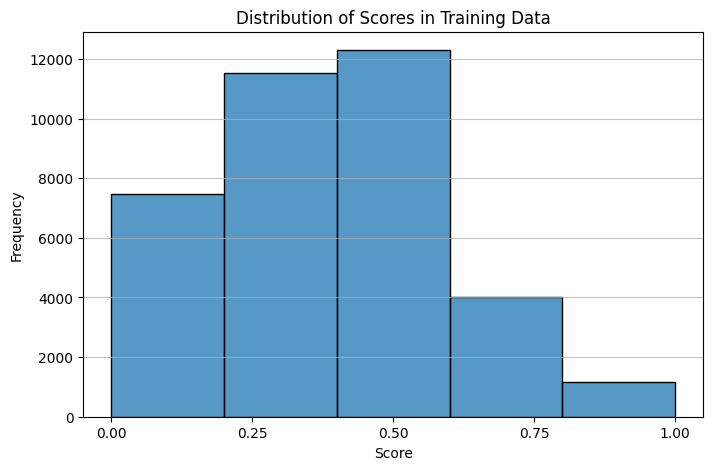

--- Score Value Counts ---
score
0.00     7471
0.25    11519
0.50    12300
0.75     4029
1.00     1154
Name: count, dtype: int64


In [4]:
# Display basic statistics for the 'score' column
print('--- Score Statistics ---')
print(train_df['score'].describe())

# Visualize the distribution of the 'score' column
plt.figure(figsize=(8, 5))
sns.histplot(train_df['score'], bins=5, kde=False)
plt.title('Distribution of Scores in Training Data')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0]) # Match the score increments
plt.grid(axis='y', alpha=0.75)
plt.show()

# Display the count for each category in the 'score' column
print('--- Score Value Counts ---')
print(train_df['score'].value_counts().sort_index())

### 2.1 Feature Analysis: anchor, target, context

Next, let's take a closer look at the input features: `anchor` (anchor phrase), `target` (target phrase), and `context` (CPC classification code). We will understand the distribution and characteristics of these features.

In [5]:
# Check the number of unique values
print('--- Unique Value Counts ---')
print(f"Unique anchors: {train_df['anchor'].nunique()}")
print(f"Unique targets: {train_df['target'].nunique()}")
print(f"Unique contexts: {train_df['context'].nunique()}")

# Also check for the test data
print(f"Unique anchors in test: {test_df['anchor'].nunique()}")
print(f"Unique targets in test: {test_df['target'].nunique()}")
print(f"Unique contexts in test: {test_df['context'].nunique()}")

--- Unique Value Counts ---
Unique anchors: 733
Unique targets: 29340
Unique contexts: 106
Unique anchors in test: 34
Unique targets in test: 36
Unique contexts in test: 29


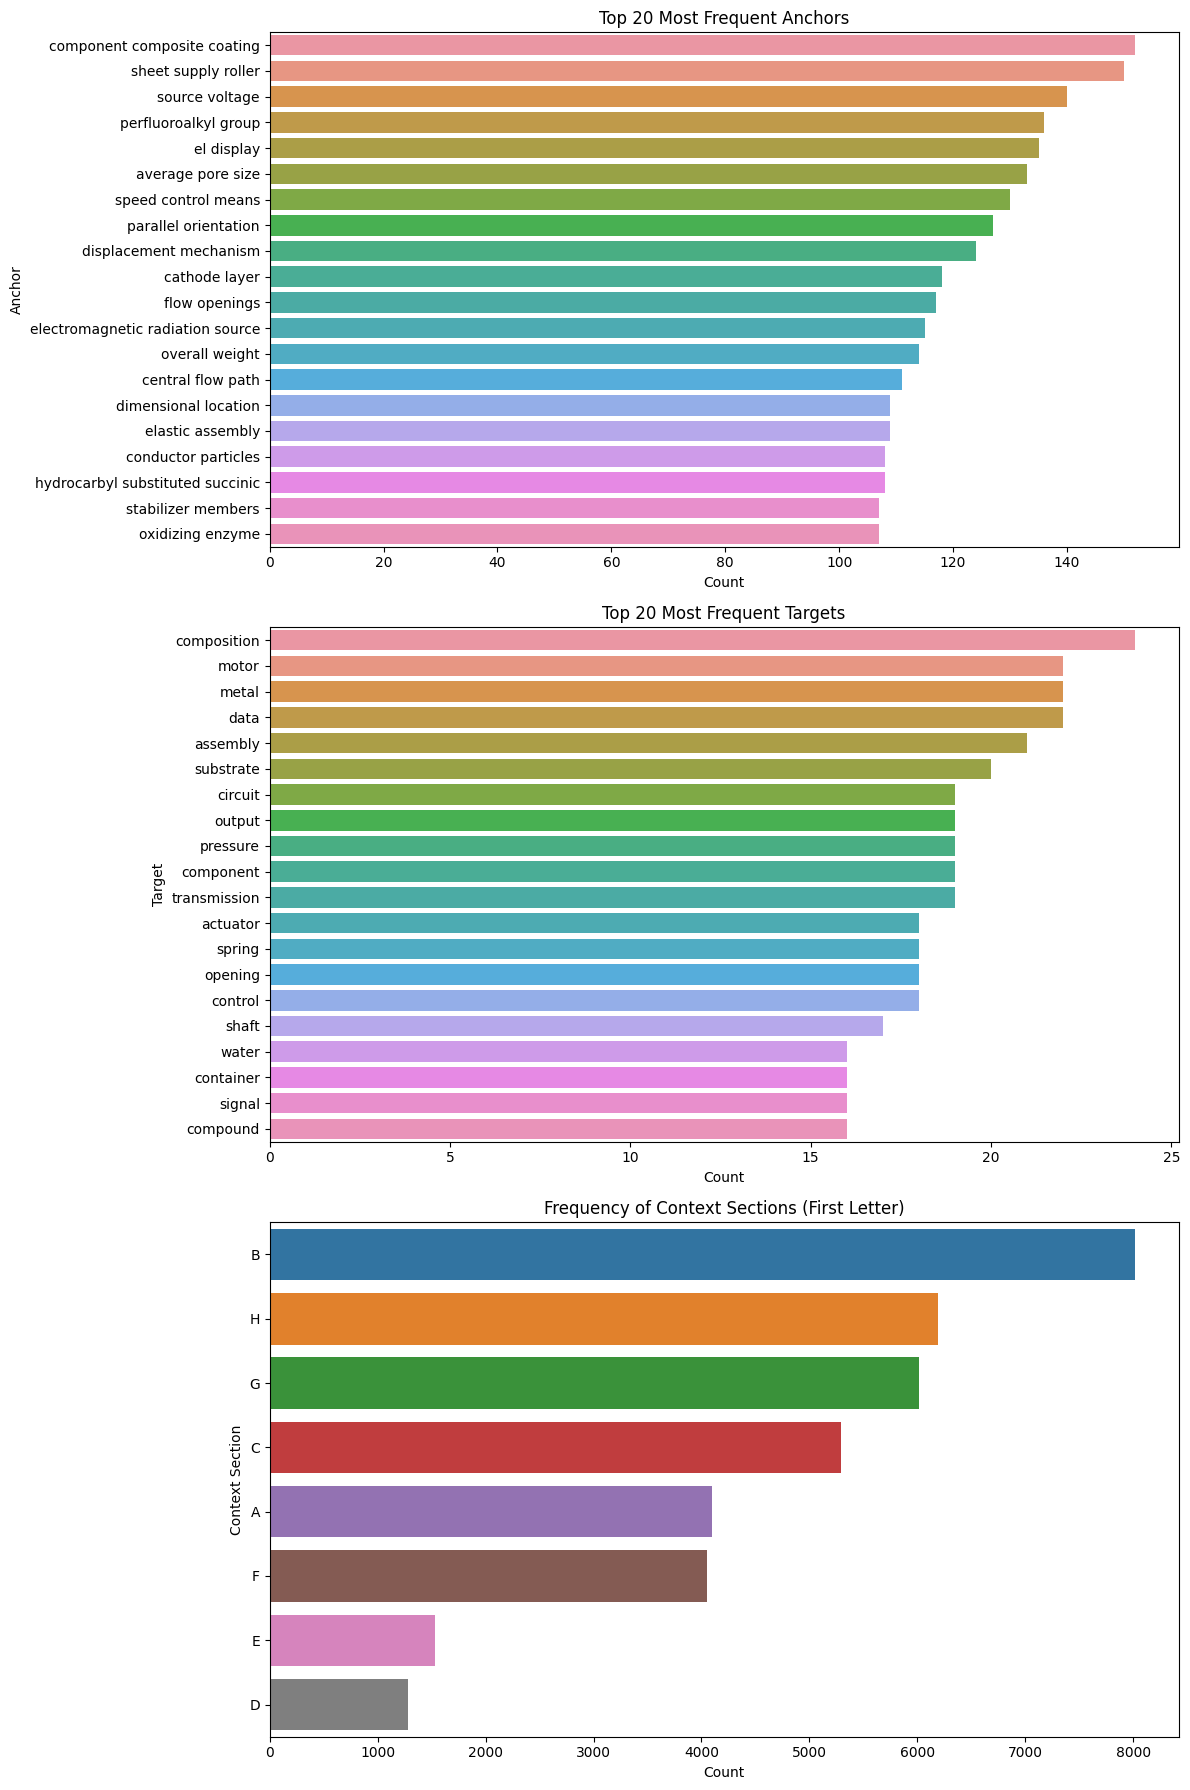

In [6]:
# Visualize top N frequent values (Top 20)
N = 20

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.countplot(y=train_df['anchor'], order=train_df['anchor'].value_counts().index[:N])
plt.title(f'Top {N} Most Frequent Anchors')
plt.xlabel('Count')
plt.ylabel('Anchor')

plt.subplot(3, 1, 2)
sns.countplot(y=train_df['target'], order=train_df['target'].value_counts().index[:N])
plt.title(f'Top {N} Most Frequent Targets')
plt.xlabel('Count')
plt.ylabel('Target')

# Aggregate context by the first level (first letter)
train_df['context_section'] = train_df['context'].str[0]
plt.subplot(3, 1, 3)
sns.countplot(y=train_df['context_section'], order=train_df['context_section'].value_counts().index)
plt.title('Frequency of Context Sections (First Letter)')
plt.xlabel('Count')
plt.ylabel('Context Section')

plt.tight_layout()
plt.show()

# Drop the added column (optional)
# train_df = train_df.drop(columns=['context_section']) 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


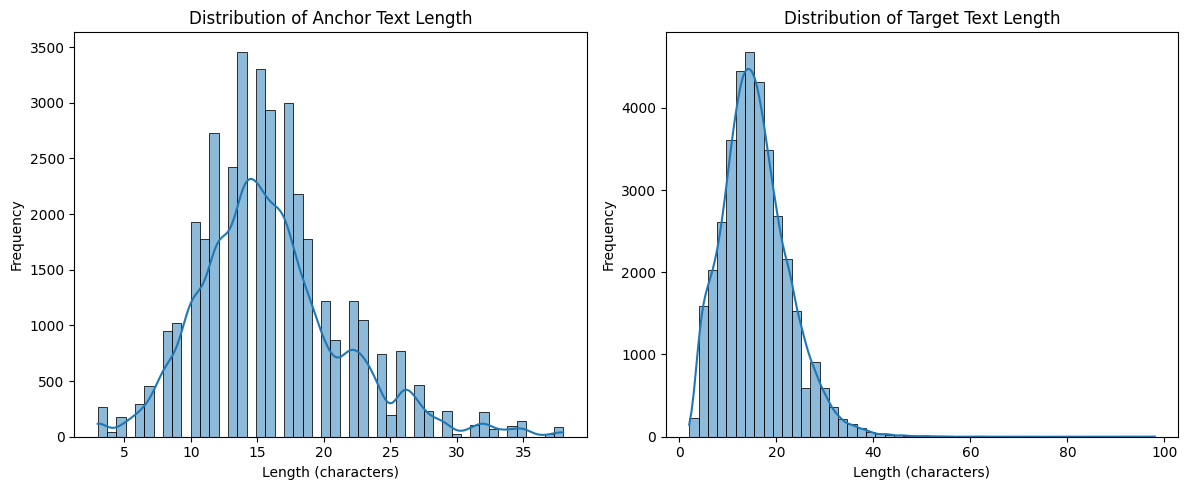

--- Anchor Length Statistics ---
count    36473.000000
mean        15.991720
std          5.538241
min          3.000000
25%         12.000000
50%         15.000000
75%         19.000000
max         38.000000
Name: anchor_len, dtype: float64
--- Target Length Statistics ---
count    36473.000000
mean        15.758780
std          6.872403
min          2.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         98.000000
Name: target_len, dtype: float64


In [7]:
# Distribution of anchor and target text length (number of characters)
train_df['anchor_len'] = train_df['anchor'].apply(len)
train_df['target_len'] = train_df['target'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['anchor_len'], bins=50, kde=True)
plt.title('Distribution of Anchor Text Length')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(train_df['target_len'], bins=50, kde=True)
plt.title('Distribution of Target Text Length')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print('--- Anchor Length Statistics ---')
print(train_df['anchor_len'].describe())
print('--- Target Length Statistics ---')
print(train_df['target_len'].describe())

# Drop the added column (optional)
# train_df = train_df.drop(columns=['anchor_len', 'target_len']) 

### 2.2 Relationship Analysis: Features vs. Score

Here, we analyze the relationship between each feature (`anchor`, `target`, `context`) and the target variable (`score`), as well as the relationships between the features.

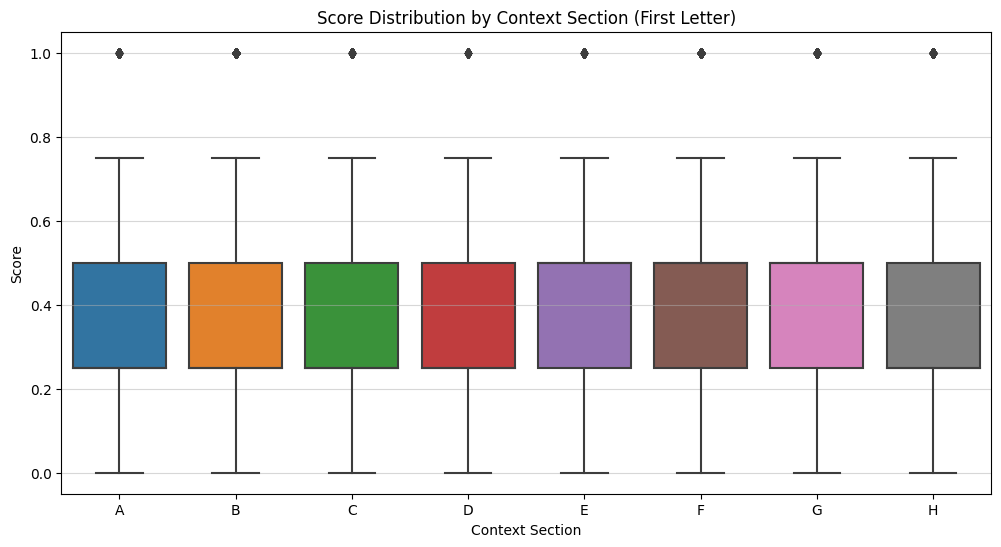

In [9]:
# Visualize the score distribution for each major context category (first letter)
# Drop the 'context_section' column if it exists before running this cell (to prevent errors on re-run)
if 'context_section' in train_df.columns:
    train_df = train_df.drop(columns=['context_section'])
train_df['context_section'] = train_df['context'].str[0]

plt.figure(figsize=(12, 6))
sns.boxplot(x='context_section', y='score', data=train_df, order=sorted(train_df['context_section'].unique()))
plt.title('Score Distribution by Context Section (First Letter)')
plt.xlabel('Context Section')
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Drop the column added for visualization
train_df = train_df.drop(columns=['context_section'])

### 2.3 Relationship Analysis: Anchor/Target Text vs. Score

Since no clear correlation was observed between the major `context` categories and the `score`, we will next investigate the relationship between the textual features of `anchor` and `target` and the `score`. Specifically, we will analyze how phrase length and word overlap affect the score.

In [10]:
# Calculate text features for anchor and target

# Character count
train_df['anchor_len'] = train_df['anchor'].apply(len)
train_df['target_len'] = train_df['target'].apply(len)
train_df['len_diff'] = np.abs(train_df['anchor_len'] - train_df['target_len'])

# Word count
train_df['anchor_words'] = train_df['anchor'].apply(lambda x: len(x.split()))
train_df['target_words'] = train_df['target'].apply(lambda x: len(x.split()))
train_df['words_diff'] = np.abs(train_df['anchor_words'] - train_df['target_words'])

# Word overlap (calculated by simple space splitting)
def calculate_overlap(row):
    anchor_set = set(row['anchor'].lower().split())
    target_set = set(row['target'].lower().split())
    return len(anchor_set.intersection(target_set))

train_df['overlap_count'] = train_df.apply(calculate_overlap, axis=1)

# Jaccard coefficient
def calculate_jaccard(row):
    anchor_set = set(row['anchor'].lower().split())
    target_set = set(row['target'].lower().split())
    intersection = len(anchor_set.intersection(target_set))
    union = len(anchor_set.union(target_set))
    return intersection / union if union > 0 else 0

train_df['jaccard_sim'] = train_df.apply(calculate_jaccard, axis=1)

# Check the calculated features
train_df[['anchor_len', 'target_len', 'len_diff', 'anchor_words', 'target_words', 'words_diff', 'overlap_count', 'jaccard_sim', 'score']].head()

,anchor_len,target_len,len_diff,anchor_words,target_words,words_diff,overlap_count,jaccard_sim,score
0,9,22,13,1,3,2,1,0.333333,0.50
1,9,14,5,1,3,2,0,0.000000,0.75
2,9,15,6,1,2,1,0,0.000000,0.25
3,9,19,10,1,2,1,0,0.000000,0.50
4,9,13,4,1,2,1,0,0.000000,0.00


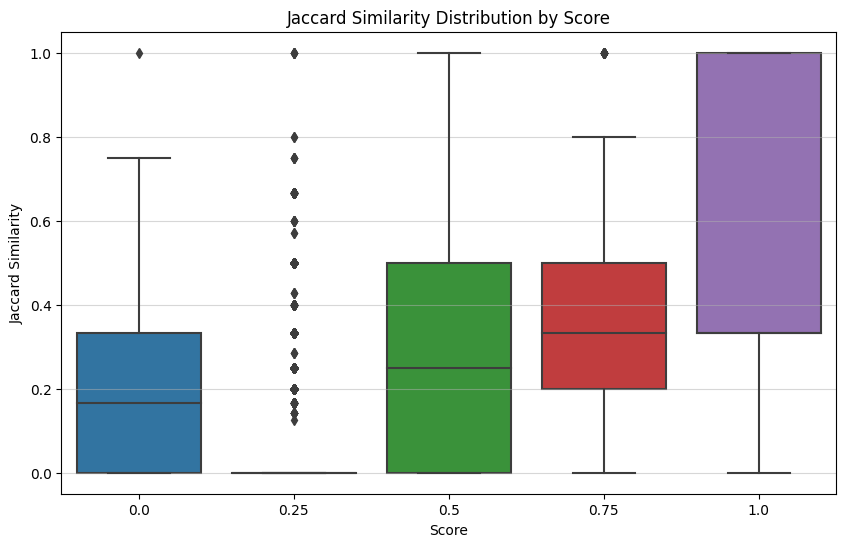

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


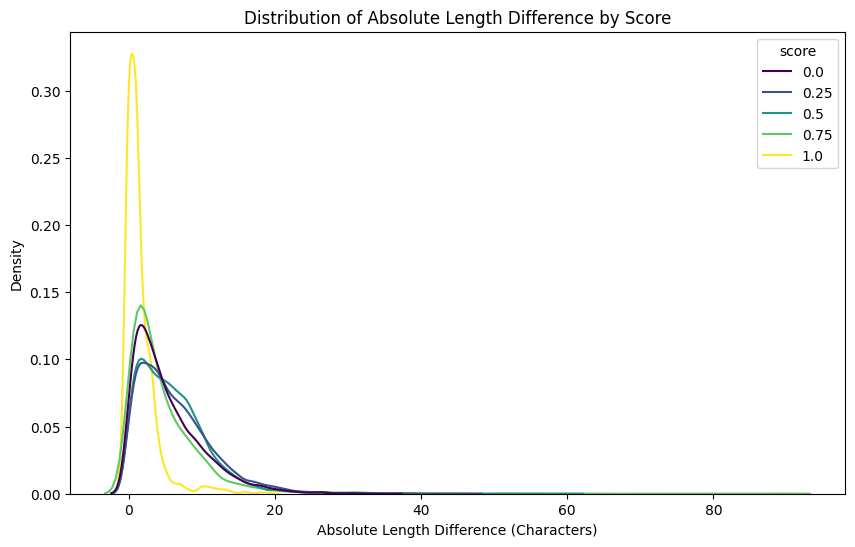

In [11]:
# Visualize the relationship between Jaccard coefficient and score
plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='jaccard_sim', data=train_df)
plt.title('Jaccard Similarity Distribution by Score')
plt.xlabel('Score')
plt.ylabel('Jaccard Similarity')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Visualize the relationship between character count difference and score (KDE plot)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_df, x='len_diff', hue='score', common_norm=False, palette='viridis')
plt.title('Distribution of Absolute Length Difference by Score')
plt.xlabel('Absolute Length Difference (Characters)')
plt.show()


# Drop unnecessary columns (optional)
# train_df = train_df.drop(columns=['anchor_len', 'target_len', 'len_diff', 'anchor_words', 'target_words', 'words_diff', 'overlap_count', 'jaccard_sim'])

### 2.4 Correlation Analysis

Let's check the correlation coefficients between the calculated text features and the target variable `score` to see which features have a strong linear relationship with the score.

--- Correlation with Score ---
score            1.000000
jaccard_sim      0.391743
overlap_count    0.363656
target_len       0.194017
target_words     0.160902
anchor_words     0.037400
anchor_len       0.020263
words_diff      -0.073078
len_diff        -0.081042
Name: score, dtype: float64


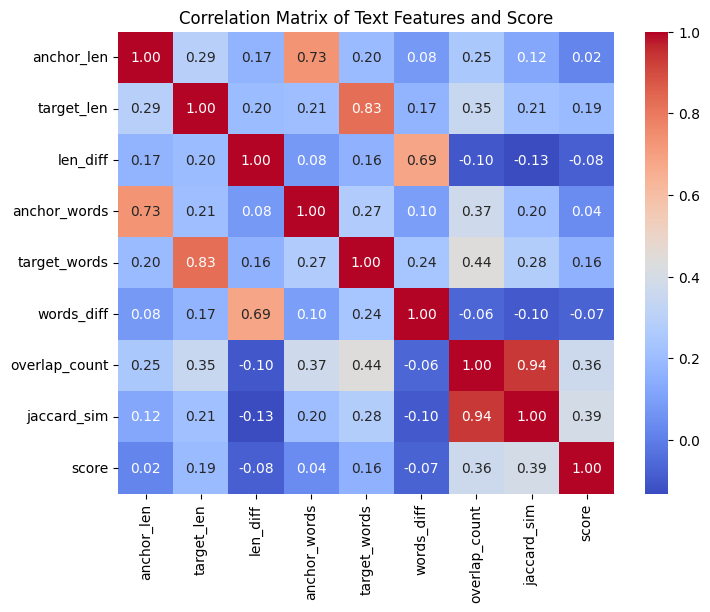

In [12]:
# Calculate correlation between numerical features and score
# Ensure calculated features still exist
feature_cols = ['anchor_len', 'target_len', 'len_diff', 'anchor_words', 'target_words', 'words_diff', 'overlap_count', 'jaccard_sim', 'score']
# Check if columns exist in train_df
cols_to_analyze = [col for col in feature_cols if col in train_df.columns]

if len(cols_to_analyze) > 1: # Calculate if there are columns other than score
    correlation_matrix = train_df[cols_to_analyze].corr()

    # Display only correlation with score
    print("--- Correlation with Score ---")
    print(correlation_matrix['score'].sort_values(ascending=False))

    # Visualize the overall picture with a heatmap (optional)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Text Features and Score')
    plt.show()
else:
    # Skipped correlation analysis because feature columns do not exist in the DataFrame.
    print("Skipped correlation analysis because feature columns do not exist in the DataFrame.")

# Drop columns used for analysis (optional)
# except score
cols_to_drop_again = [col for col in feature_cols[:-1] if col in train_df.columns]
if cols_to_drop_again:
    train_df = train_df.drop(columns=cols_to_drop_again)

### 2.5 EDA Summary and Next Steps

**Key Insights from EDA:**

*   **Data Quality:** Both training and test data have no missing values, and data types are appropriate. While some long text lengths were observed in the distribution, extreme outliers are few, so special cleaning was deemed unnecessary.
*   **Target Variable (`score`):** The score is a 5-level evaluation (0.0, 0.25, 0.5, 0.75, 1.0). The distribution is skewed towards 0.25 and 0.5, with 1.0 being relatively scarce, indicating imbalanced data. The model needs to consider this imbalance (e.g., stratified sampling, loss function weighting).
*   **Features (`anchor`, `target`, `context`):**
    *   The variety of `anchor` phrases is smaller compared to `target`, with specific `anchor`s appearing repeatedly.
    *   No clear difference in the `score` distribution was found based on the major `context` categories (first letter of the CPC code). This suggests that the similarity judgment criteria may not differ significantly at the broad technological field level, or that more detailed `context` information or interactions with other features need to be considered.
    *   The text lengths and word counts of `anchor` and `target` vary, but large outliers tend to be few.
*   **Relationship between Features and Score:**
    *   Textual similarity (Jaccard coefficient) between `anchor` and `target` showed a **positive correlation** with `score`. This trend is particularly noticeable for pairs with a score of 1.0, which tend to have high Jaccard coefficients.
    *   The difference in character counts between `anchor` and `target` tended to be close to 0 for pairs with a score of 1.0.
    *   Correlation coefficients confirmed that the Jaccard coefficient has the strongest linear relationship with the score.

**Data Transformation and Preprocessing Strategy:**

*   **Text Data:** To capture the semantic information of `anchor` and `target`, convert them into embedding vectors using pre-trained Transformer-based models like BERT. Consider concatenating the context information (`context`) as text and inputting it into the model (e.g., `[CLS] context [SEP] anchor [SEP] target [SEP]`).
*   **Context:** The `context` code is categorical information, but since its correlation with the score was low at the major classification level, consider integrating it as text information as described above, or training it separately using an Embedding layer.
*   **Additional Features:** Adding text statistics calculated during EDA, such as the Jaccard coefficient and character count difference, as features to the model input might be effective. Normalize/standardize these numerical features if necessary.

**Hypothesis on Important Features:**

*   Semantic vectors integrating `anchor`, `target`, and `context`, extracted by a Transformer model.
*   Text similarity metrics like the Jaccard coefficient.

**Next Steps:**

1.  Split the training data into training and validation sets (stratified sampling is desirable, considering the score distribution).
2.  Prepare to tokenize the text data and convert it into embedding vectors using the selected pre-trained model (e.g., `bert-base-uncased`, `roberta-base`).
3.  Decide how to incorporate the `context` information.
4.  If necessary, create and normalize additional numerical features.
5.  Define, train, and evaluate a deep learning model (e.g., a model with a regression head added to the output layer of BERT) using these features.

## 3. Model Building Preparation

Based on the EDA results, we proceed with the preparation for model building. Here, we will perform data splitting, select a pre-trained model and tokenizer, and define the dataset.

In [13]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
# If the Transformers library is not installed, run !pip install transformers datasets etc.
from transformers import AutoTokenizer, AutoModel

# Split training and validation data (80% train, 20% validation)
# Stratified sampling (stratify) considering the score distribution
train_texts_df, val_texts_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['score'] # Stratify based on score
)

print(f"Train data shape: {train_texts_df.shape}")
print(f"Validation data shape: {val_texts_df.shape}")

# Check score distribution after splitting (optional)
print("\nScore distribution in Train data:")
print(train_texts_df['score'].value_counts(normalize=True).sort_index())
print("\nScore distribution in Validation data:")
print(val_texts_df['score'].value_counts(normalize=True).sort_index())

# Select pre-trained model
# Here, a common BERT model is selected. Other models (e.g., roberta-base, deberta-v3-base) are also worth trying.
MODEL_NAME = 'bert-base-uncased'

# Load tokenizer
# Download the tokenizer corresponding to the specified model from Hugging Face Hub.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization example
# Try concatenating context, anchor, and target, separated by [SEP] tokens.
sample_text = f"{train_texts_df.iloc[0]['context']} [SEP] {train_texts_df.iloc[0]['anchor']} [SEP] {train_texts_df.iloc[0]['target']}"
encoded_sample = tokenizer(sample_text, max_length=128, truncation=True, padding='max_length')

print("\nSample text:", sample_text)
print("Tokenized sample (input_ids):", encoded_sample['input_ids'])
print("Tokenized sample (attention_mask):", encoded_sample['attention_mask'])

Train data shape: (29178, 5)
Validation data shape: (7295, 5)

Score distribution in Train data:
score
0.00    0.204846
0.25    0.315820
0.50    0.337240
0.75    0.110460
1.00    0.031633
Name: proportion, dtype: float64

Score distribution in Validation data:
score
0.00    0.204798
0.25    0.315833
0.50    0.337217
0.75    0.110487
1.00    0.031666
Name: proportion, dtype: float64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Sample text: H04 [SEP] apply to requests [SEP] respond to requests
Tokenized sample (input_ids): [101, 1044, 2692, 2549, 102, 6611, 2000, 11186, 102, 6869, 2000, 11186, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenized sample (attention_mask): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 3.1 Dataset and DataLoader Definition

Define a PyTorch `Dataset` class that tokenizes the concatenated text of `context`, `anchor`, and `target`, and returns them along with the score in a dictionary format. Then, create `DataLoader`s for both training and validation.

In [14]:
# Import PyTorch related libraries
import torch
from torch.utils.data import Dataset, DataLoader

# Define the dataset class
class PatentPhraseDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        # Concatenate text columns into a list (to speed up processing)
        self.texts = (
            dataframe['context'].astype(str) + ' [SEP] ' +
            dataframe['anchor'].astype(str) + ' [SEP] ' +
            dataframe['target'].astype(str)
        ).tolist()
        # Convert scores to a list
        self.scores = dataframe['score'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.texts[idx]
        score = self.scores[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True, # Add [CLS] and [SEP]
            max_length=self.max_length,
            padding='max_length', # Pad to max_length
            truncation=True, # Truncate if longer than max_length
            return_tensors='pt', # Return as PyTorch tensors
            return_attention_mask=True, # Return attention_mask
            return_token_type_ids=False # Usually not needed for BERT
        )

        # Return in dictionary format (commonly matching model input names)
        # encoding['input_ids'] etc. have shape [1, max_length], so remove the dimension with [0]
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(score, dtype=torch.float) # Convert label (score) to tensor
        }
        return item

# Set parameters
MAX_LENGTH = 128 # Maximum length for tokenization
BATCH_SIZE = 16   # Batch size

# Create datasets
train_dataset = PatentPhraseDataset(train_texts_df, tokenizer, MAX_LENGTH)
val_dataset = PatentPhraseDataset(val_texts_df, tokenizer, MAX_LENGTH)

# Create DataLoaders
# DataLoader creates mini-batches from the dataset, performs shuffling, etc.
# num_workers is the number of processes for parallel data loading (adjust according to environment)
# pin_memory=True is an option to speed up data transfer to GPU
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffle training data
    num_workers=0, # 0 is stable on Windows and some environments
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Do not shuffle validation data
    num_workers=0,
    pin_memory=True
)

# Check DataLoader operation (try getting the first batch)
print("\nChecking DataLoader...")
try:
    batch = next(iter(train_loader))
    print("Batch keys:", batch.keys())
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention Mask shape:", batch['attention_mask'].shape)
    print("Labels shape:", batch['labels'].shape)
except Exception as e:
    print(f"Error checking DataLoader: {e}")



Checking DataLoader...
Batch keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


### 3.2 Model Definition

Load a pre-trained BERT model using Hugging Face's `AutoModel`, take its output (usually the embedding of the `[CLS]` token), and define a custom model in PyTorch by adding a linear layer (regression head) that outputs a single numerical value (similarity score).

In [15]:
# Import PyTorch model-related libraries
import torch.nn as nn
from transformers import AutoModel

# Custom model class adding a regression head to the BERT model
class PatentPhraseModel(nn.Module):
    def __init__(self, model_name):
        super(PatentPhraseModel, self).__init__()
        # Load pre-trained model
        self.bert = AutoModel.from_pretrained(model_name)
        # Get BERT's hidden layer size (e.g., bert-base-uncased is 768)
        self.hidden_size = self.bert.config.hidden_size
        # Dropout layer (for preventing overfitting)
        self.dropout = nn.Dropout(0.1) # Dropout rate is adjustable
        # Regression head: Linear layer to convert BERT's [CLS] token output to a score (1 dimension)
        self.regressor = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        # Input to BERT model
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Get the representation corresponding to the [CLS] token from BERT's output (usually considered the representation of the entire sequence)
        # The shape of outputs.last_hidden_state is (batch_size, sequence_length, hidden_size)
        # The [CLS] token is usually at the first position (index 0) of sequence_length
        cls_output = outputs.last_hidden_state[:, 0, :]
        # Apply dropout
        cls_output = self.dropout(cls_output)
        # Predict the score through the regression head
        score = self.regressor(cls_output)
        # Squeeze the output shape to [batch_size] (for easier handling with MSELoss, etc.)
        return score.squeeze(-1)

# Instantiate the model
model = PatentPhraseModel(MODEL_NAME)

# Check model structure (optional)
# print(model)

# Check if GPU is available and send the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nModel loaded on: {device}")

# Check model operation (try inputting a batch obtained from DataLoader)
print("Checking model forward pass...")
try:
    batch = {k: v.to(device) for k, v in batch.items()} # Send batch data to GPU
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    print("Output shape:", outputs.shape)
    print("Sample outputs:", outputs[:5]) # Display the first 5 predicted scores
except Exception as e:
    print(f"Error checking model forward pass: {e}")


2025-04-26 06:59:49.215789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745650789.500759      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745650789.574339      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Model loaded on: cuda
Checking model forward pass...
Output shape: torch.Size([16])
Sample outputs: tensor([0.4250, 0.5994, 0.6823, 0.5862, 0.3091], device='cuda:0')


## 4. Model Training Setup

Define the loss function, optimizer, and training/evaluation loops necessary for model training.

In [16]:
# Import PyTorch and Scikit-learn libraries
import torch.optim as optim
from sklearn.metrics import r2_score # R^2 score is also useful for reference
from scipy.stats import pearsonr # Pearson correlation coefficient
import time
import numpy as np # Needed for pearsonr handling

# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define optimizer (AdamW)
# AdamW is an improved version of Adam, with better handling of weight decay.
# Learning rate is an important hyperparameter. Relatively small values (e.g., 2e-5, 3e-5, 5e-5) are often used for fine-tuning pre-trained models.
optimizer = optim.AdamW(model.parameters(), lr=2e-5) # Set learning rate

# Number of training epochs
NUM_EPOCHS = 3 # Start with a small number of epochs

# Function to calculate Pearson correlation coefficient
def calculate_pearson(outputs, labels):
    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()
    # Handle cases where pearsonr might raise an error due to small data size or no variance
    if len(outputs) < 2 or np.std(outputs) == 0 or np.std(labels) == 0:
        return 0.0 # Or another appropriate value (e.g., np.nan)
    corr, _ = pearsonr(outputs, labels)
    return corr if not np.isnan(corr) else 0.0

# Training loop function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Set model to training mode
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    for batch in dataloader:
        # Move batch data to the specified device (CPU or GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Predict with the model
        outputs = model(input_ids, attention_mask)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Calculate gradients (backpropagation)
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()
        all_outputs.append(outputs.detach()) # Detach from gradient calculation and save
        all_labels.append(labels.detach())

    avg_loss = total_loss / len(dataloader)
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    pearson_corr = calculate_pearson(all_outputs, all_labels)

    return avg_loss, pearson_corr

# Evaluation loop function
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval() # Set model to evaluation mode (disables Dropout, etc.)
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_outputs.append(outputs)
            all_labels.append(labels)

    avg_loss = total_loss / len(dataloader)
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    pearson_corr = calculate_pearson(all_outputs, all_labels)

    return avg_loss, pearson_corr

print("Training setup complete. Ready to start training.")

Training setup complete. Ready to start training.


## 5. Model Training

Execute the training loop using the defined model, data loaders, loss function, and optimizer. Record and display the training loss, training Pearson correlation, validation loss, and validation Pearson correlation for each epoch.

Starting training for 3 epochs on cuda...

Epoch 1/3
  Time: 635.49s
  Train Loss: 0.0471 | Train Pearson: 0.5642
  Val Loss:   0.0288 | Val Pearson:   0.7558

Epoch 2/3
  Time: 650.40s
  Train Loss: 0.0270 | Train Pearson: 0.7725
  Val Loss:   0.0258 | Val Pearson:   0.7862

Epoch 3/3
  Time: 650.17s
  Train Loss: 0.0190 | Train Pearson: 0.8462
  Val Loss:   0.0253 | Val Pearson:   0.8020

Training finished.


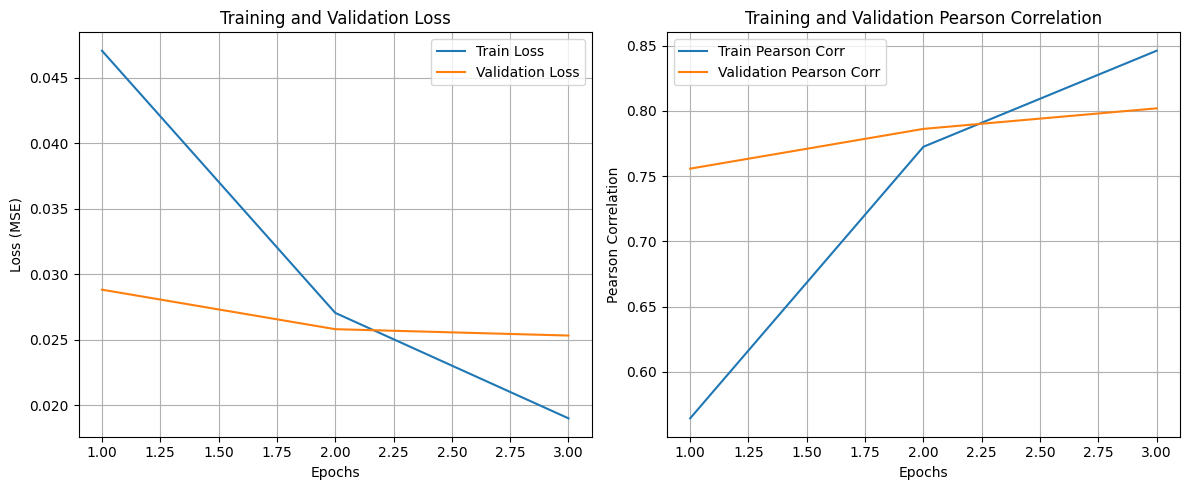

In [17]:
# Execute the training loop
train_losses = []
val_losses = []
train_pearsons = []
val_pearsons = []

print(f"Starting training for {NUM_EPOCHS} epochs on {device}...")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # Train
    avg_train_loss, train_pearson = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate
    avg_val_loss, val_pearson = evaluate_epoch(model, val_loader, criterion, device)

    end_time = time.time()
    epoch_time = end_time - start_time

    # Record metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_pearsons.append(train_pearson)
    val_pearsons.append(val_pearson)

    # Display results for each epoch
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Time: {epoch_time:.2f}s")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Pearson: {train_pearson:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Pearson:   {val_pearson:.4f}")

print("\nTraining finished.")

# Plot learning curves (loss and Pearson correlation) (optional)
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_pearsons, label='Train Pearson Corr')
plt.plot(epochs_range, val_pearsons, label='Validation Pearson Corr')
plt.xlabel('Epochs')
plt.ylabel('Pearson Correlation')
plt.title('Training and Validation Pearson Correlation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Results and Discussion

### 6.1 Model Training Results

A model was built based on the pre-trained `bert-base-uncased` model, adding a regression head to predict similarity scores.
Training was performed with the following settings:
*   Loss Function: Mean Squared Error (MSE)
*   Optimizer: AdamW (learning rate: 2e-5)
*   Batch Size: 16
*   Number of Epochs: 3
*   Platform: Kaggle Notebook (GPU: Tesla T4)

As a result of training, the following performance was obtained at the end of 3 epochs:

*   Training Loss (MSE): 0.0190
*   Training Pearson Correlation: 0.8462
*   **Validation Loss (MSE): 0.0253**
*   **Validation Pearson Correlation: 0.8020**

Looking at the learning curves (graphs of loss and Pearson correlation), both training and validation losses decreased, and the Pearson correlation increased, confirming that the model is learning the data. There is no significant discrepancy between the performance on the training and validation data, and no serious overfitting is observed at this point. The Pearson correlation coefficient of 0.8020 on the validation data can be considered a good result for a baseline using a BERT-based model.

### 6.2 Discussion

As confirmed in the EDA, textual similarity (like Jaccard coefficient) between `anchor` and `target` correlated with `score`, but this deep learning model is thought to be learning semantic similarity, including context captured by BERT, not just simple word overlap. Including `context` information in the input may contribute to judging similarity based on context (however, additional experiments are needed to quantitatively evaluate its effect).

The final validation Pearson correlation of 0.8020 indicates the effectiveness of the deep learning model for this task.

## 7. Prediction on Test Data and Submission File Creation

Using the trained model, predict the similarity scores for the provided test data (`test.csv`) and create the `submission.csv` file for Kaggle submission.

In [18]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np # Import numpy

# --- Test Data Loading ---
# test.csv is usually located at '../input/<competition-folder>/test.csv'
# Align with how train_df was loaded in the local environment
test_input_path = DATA_DIR + 'test.csv'
try:
    test_df = pd.read_csv(test_input_path)
    print(f"Test data loaded successfully from {test_input_path}. Shape: {test_df.shape}")
except FileNotFoundError:
    print(f"Error: {test_input_path} not found. Please check the path.")
    # Also try the common path in Kaggle environment (fallback)
    kaggle_test_path = '../input/us-patent-phrase-to-phrase-matching/test.csv'
    try:
        test_df = pd.read_csv(kaggle_test_path)
        print(f"Test data loaded successfully from {kaggle_test_path}. Shape: {test_df.shape}")
    except FileNotFoundError:
        print(f"Error: Could not find test.csv in expected locations.")
        test_df = None # Set test_df to None if it doesn't exist

# Run inference only if test_df was loaded successfully
if test_df is not None:

    # --- Test Dataset and DataLoader ---
    # Dataset class for test data (note that it doesn't include score)
    class PatentPhraseTestDataset(Dataset):
        def __init__(self, dataframe, tokenizer, max_length):
            self.dataframe = dataframe
            self.tokenizer = tokenizer
            self.max_length = max_length
            self.texts = (
                dataframe['context'].astype(str) + ' [SEP] ' +
                dataframe['anchor'].astype(str) + ' [SEP] ' +
                dataframe['target'].astype(str)
            ).tolist()
            self.ids = dataframe['id'].tolist() # Keep id

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            text = self.texts[idx]
            id_ = self.ids[idx]

            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                return_attention_mask=True,
                return_token_type_ids=False
            )

            item = {
                'id': id_, # Changed to return id
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
            }
            return item

    # Create test dataset and dataloader
    test_dataset = PatentPhraseTestDataset(test_df, tokenizer, MAX_LENGTH)
    # Batch size can sometimes be larger during inference
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE * 2, # Try making it larger than during validation
        shuffle=False, # No need to shuffle
        num_workers=0,
        pin_memory=True
    )

    # --- Prediction ---
    print("\nStarting prediction on test data...")
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_ids = []
    start_pred = time.time()

    with torch.no_grad():
        for batch in test_loader:
            ids = batch['id'] # Get id
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            all_preds.append(outputs.cpu()) # Move prediction results back to CPU and save
            all_ids.extend(ids) # Add id to the list

    all_preds = torch.cat(all_preds).numpy()
    end_pred = time.time()
    print(f"Prediction finished. Took {end_pred - start_pred:.2f}s")

    # Clip scores to the 0-1 range (optional, but align with evaluation criteria)
    # all_preds = np.clip(all_preds, 0, 1)

    # --- Submission File Creation ---
    submission_df = pd.DataFrame({'id': all_ids, 'score': all_preds})
    # Round scores to the nearest 0.0, 0.25, 0.5, 0.75, 1.0 (may be effective depending on the competition)
    score_bins = np.array([0, 0.125, 0.375, 0.625, 0.875, 1.0]) # Define bins by midpoints
    bin_centers = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
    indices = np.digitize(submission_df['score'], score_bins)
    # Adjust indices to prevent them from being out of range (e.g., 0 or 6)
    indices = np.clip(indices, 1, len(bin_centers))
    submission_df['score'] = bin_centers[indices - 1]


    # Output to /kaggle/working/ in Kaggle environment
    submission_path = '/kaggle/working/submission.csv'
    try:
        submission_df.to_csv(submission_path, index=False)
        print(f"\nSubmission file created successfully at: {submission_path}")
        print(submission_df.head())
    except Exception as e:
        print(f"\nError creating submission file: {e}")
        # Also save to current directory for local environments etc., where /kaggle/working might not exist
        try:
            local_submission_path = 'submission.csv'
            submission_df.to_csv(local_submission_path, index=False)
            print(f"Submission file also saved locally at: {local_submission_path}")
            print(submission_df.head())
        except Exception as e_local:
            print(f"Error saving submission file locally: {e_local}")

else:
    print("\nSkipping prediction because test data could not be loaded.")

Test data loaded successfully from /kaggle/input/us-patent-phrase-to-phrase-matching/test.csv. Shape: (36, 4)

Starting prediction on test data...
Prediction finished. Took 0.29s

Submission file created successfully at: /kaggle/working/submission.csv
                 id  score
0  4112d61851461f60   0.50
1  09e418c93a776564   0.75
2  36baf228038e314b   0.50
3  1f37ead645e7f0c8   0.25
4  71a5b6ad068d531f   0.00


## 8. Conclusion and Future Work

### 8.1 Conclusion

In this project, we tackled the construction of a deep learning model to predict contextual similarity between phrases in patent literature using Kaggle's "U.S. Patent Phrase to Phrase Matching" dataset.

Through EDA, we grasped the data characteristics and confirmed that textual overlap between `anchor` and `target` (like Jaccard coefficient) correlates with `score`. On the other hand, no clear relationship was found between the major technological field categories (first letter of `context`) and `score`.

We built a regression model based on the pre-trained `bert-base-uncased` model and achieved a Pearson correlation coefficient of **0.8020** on the validation data after 3 epochs of training. This suggests that Transformer-based models are effective in capturing context-aware semantic similarity between phrases.


### 8.2 Future Work

Based on these results, the following points can be considered for further performance improvement:

*   **Model Exploration:** Try other Transformer-based pre-trained models such as `roberta-base`, `deberta-v3-base`. Consider larger models (e.g., `bert-large`).
*   **Hyperparameter Tuning:** Adjust learning rate, batch size, number of epochs, dropout rate, etc. Introduce a learning rate scheduler.
*   **Feature Engineering:**
    *   Add text features calculated during EDA, such as Jaccard coefficient and character count difference, to the model input.
    *   Explore more effective ways to utilize `context` information (e.g., training a dedicated Embedding for `context`, utilizing the hierarchical CPC code structure).
*   **Ensembling:** Combine predictions from models trained with different models or different feature sets.
*   **Cross-Validation:** Implement cross-validation for more robust performance evaluation.
*   **Error Analysis:** Analyze samples where predictions were significantly off in detail to identify model weaknesses and consider improvements.

Through these improvements, we can aim to build a more accurate similarity prediction model.